# EfficientNetB5

In [17]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

2022-11-09 15:10:43.403894: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 15:10:43.404415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-09 15:10:43.443795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:10:43.444011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 15:10:43.444050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:10:43.451415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0, 1


In [3]:
device_lib.list_local_devices()

2022-11-09 15:11:09.956411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16501784725935714801,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10289874240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5345776598974672370
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10552922624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 539308969366735820
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"]

2022-11-09 15:11:09.957629: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 15:11:10.115371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:11:10.115674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 15:11:10.115730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:11:10.116008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00

# Preprocess Adience Dataset

In [4]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [5]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
total_data.head()

user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34

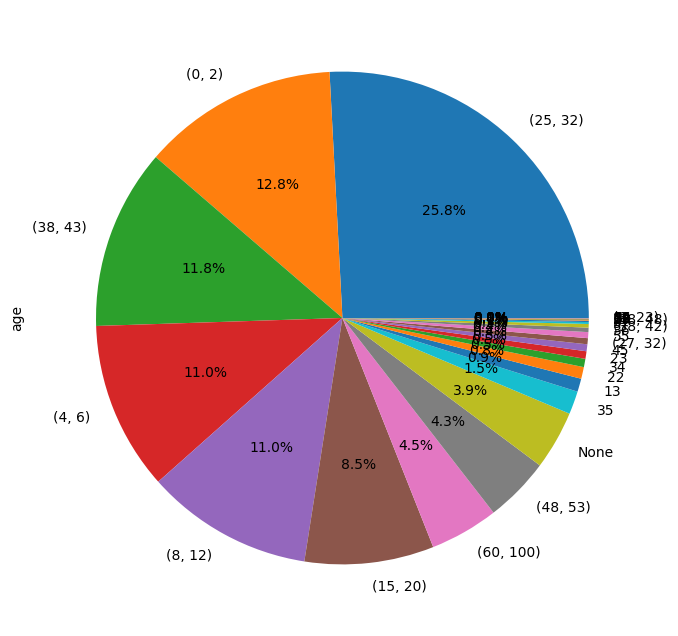

In [7]:
# pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


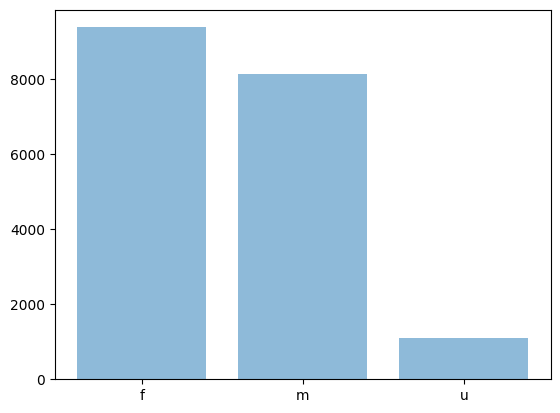

In [8]:
# bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [9]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/tmp/ipykernel_3282/3604610946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [11]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [12]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

age  gender     x     y    dx    dy  \
0    4       0     0   414  1086  1383   
1    4       1   301   105   640   641   
2    4       0  2395   876   771   771   
3    4       1   752  1255   484   485   
4    4       1   175    80   769   768   

                                            img_path  
0  ./Adience/faces/30601258@N03/coarse_tilt_align...  
1  ./Adience/faces/30601258@N03/coarse_tilt_align...  
2  ./Adience/faces/30601258@N03/coarse_tilt_align...  
3  ./Adience/faces/30601258@N03/coarse_tilt_align...  
4  ./Adience/faces/30601258@N03/coarse_tilt_align...

# Create Dataset

In [13]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [14]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


# Create Model
---
## Hyperparameters

In [18]:
batch_size = 32
epochs = 20
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 5
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

In [19]:
# init your model here before complilation
model = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape)

# input (1, 227, 227, 3) -> output (1, 5, 5, 2048)

2022-11-09 15:14:19.951352: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 15:14:19.951484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:14:19.951838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 15:14:19.951889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:14:19.952213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00

115269632/115263384 [==============================] - 12s 0us/step


Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 227, 227, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.514339 to fit



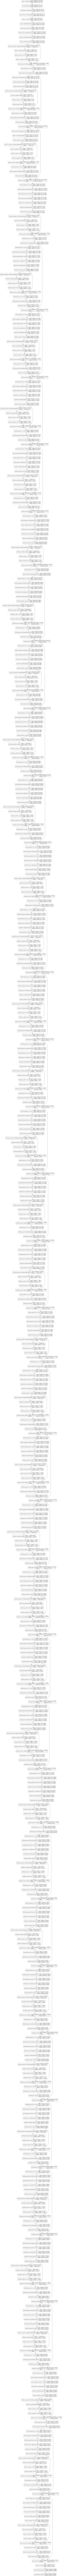

In [20]:
# visualize your model

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)
# plot_model(model)

In [23]:
# Freeze the pre-trained weights initially to train the added layers first
model.trainable = False 

# Adding custom Layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
# 2 -> 1
predictions = Dense(1, activation="sigmoid")(x)

https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances 

In [24]:
# creating the final model 
our_model = Model(inputs=model.input, outputs=predictions)
our_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 227, 227, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [25]:
our_model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    mcp = ModelCheckpoint('model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrd, mcp, es]

In [27]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [28]:
# training
history = our_model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-09 15:16:34.745136: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2022-11-09 15:16:35.281345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-09 15:16:35.300904: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


Epoch 1/20


2022-11-09 15:16:41.160111: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-09 15:16:41.317997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-09 15:16:41.968904: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-11-09 15:16:42.074917: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:42.075023: W tensorflow/str

2022-11-09 15:16:44.577675: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:44.681972: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:44.785087: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:44.891299: W tensorflow/stream_executor/gpu/

2022-11-09 15:16:47.490625: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:47.594624: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:47.700076: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:47.804286: W tensorflow/stream_executor/gpu/

2022-11-09 15:16:50.441309: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:50.545456: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:50.651212: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:50.755707: W tensorflow/stream_executor/gpu/

2022-11-09 15:16:53.384436: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:53.488813: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:53.594100: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:53.699563: W tensorflow/stream_executor/gpu/

2022-11-09 15:16:56.337299: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:56.445022: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:56.551232: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:56.657006: W tensorflow/stream_executor/gpu/

2022-11-09 15:16:59.314767: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:59.419370: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:59.524821: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:16:59.629236: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:02.250359: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:02.354924: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:02.461337: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:02.565666: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:05.199726: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:05.302794: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:05.407795: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:05.512508: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:08.146892: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:08.251312: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:08.356525: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:08.460798: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:11.084776: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:11.188838: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:11.293477: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:11.397559: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:14.015136: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:14.118148: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:14.222838: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:14.325435: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:16.937412: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:17.041654: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:17.147649: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:17.250880: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:19.906620: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:20.014376: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:20.120475: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:20.225110: W tensorflow/stream_executor/gpu/

2022-11-09 15:17:22.869486: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:22.973207: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:23.078843: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:23.182846: W tensorflow/stream_executor/gpu/

  1/382 [..............................] - ETA: 5:14:55 - loss: 0.7060 - accuracy: 0.4062

2022-11-09 15:17:24.797102: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:17:24.901449: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



381/382 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8015

2022-11-09 15:18:01.549222: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:01.656697: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:01.764069: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:01.870334: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:04.557099: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:04.663905: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:04.771454: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:04.877923: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:07.661760: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:07.768798: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:07.876085: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:07.984480: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:10.692962: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:10.800779: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:10.909093: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:11.017453: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:13.728971: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:13.836431: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:13.944753: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:14.055703: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:16.766909: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:16.875574: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:16.983643: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:17.093237: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:19.819211: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:19.928809: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:20.037794: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:20.146077: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:22.858534: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:22.967393: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:23.078467: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:23.193507: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:25.900805: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:26.008810: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:26.117803: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:26.224610: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:28.940060: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:29.048952: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:29.157389: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:29.267190: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:31.978861: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:32.088173: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:32.196458: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:32.304756: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:35.028954: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:35.138676: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:35.247236: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:35.355433: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:38.072459: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:38.181436: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:38.289744: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:38.398457: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:41.265380: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:41.387853: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:41.495903: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:41.608465: W tensorflow/stream_executor/gpu/

2022-11-09 15:18:44.319027: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:44.427897: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:44.536089: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:18:44.659366: W tensorflow/stream_executor/gpu/

382/382 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8016

2022-11-09 15:18:46.090046: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:04.483437: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:04.603214: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:04.723763: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:07.595671: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:07.714216: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:07.834603: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:07.953441: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:11.168315: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:11.288555: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:11.411327: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:11.533167: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:14.567809: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:14.691710: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:14.815452: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:14.934650: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:17.999182: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:18.120976: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:18.243876: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:18.367076: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:21.440620: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:21.562766: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:21.685812: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:21.808001: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:24.878481: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:25.000109: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:25.127798: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:25.250792: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:28.306555: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:28.429505: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:28.552688: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:28.674885: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:31.747888: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:31.870281: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:31.989452: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:32.111658: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:35.199963: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:35.322845: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:35.448035: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:35.571418: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:38.671554: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:38.794475: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:38.914292: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:39.036489: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:42.138393: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:42.261457: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:42.386227: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:42.509277: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:45.595935: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:45.719242: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:45.842784: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:45.961957: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:49.070223: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:49.193438: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:49.330083: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:49.454442: W tensorflow/stream_executor/gpu/

2022-11-09 15:19:52.545495: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:52.668471: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:52.792703: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:52.911616: W tensorflow/stream_executor/gpu/

382/382 [==============================] - 199s 393ms/step - loss: 0.4121 - accuracy: 0.8017 - val_loss: 0.3016 - val_accuracy: 0.8673


2022-11-09 15:19:54.551134: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 15:19:54.674218: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



Epoch 2/20
382/382 [==============================] - 53s 139ms/step - loss: 0.3072 - accuracy: 0.8674 - val_loss: 0.2831 - val_accuracy: 0.8831
Epoch 3/20
382/382 [==============================] - 54s 143ms/step - loss: 0.2735 - accuracy: 0.8782 - val_loss: 0.2726 - val_accuracy: 0.8904
Epoch 4/20
382/382 [==============================] - 55s 144ms/step - loss: 0.2518 - accuracy: 0.8896 - val_loss: 0.2546 - val_accuracy: 0.8976
Epoch 5/20
382/382 [==============================] - 55s 144ms/step - loss: 0.2287 - accuracy: 0.9052 - val_loss: 0.2493 - val_accuracy: 0.9015
Epoch 6/20
382/382 [==============================] - 55s 144ms/step - loss: 0.2046 - accuracy: 0.9171 - val_loss: 0.2409 - val_accuracy: 0.9047
Epoch 7/20
382/382 [==============================] - 55s 144ms/step - loss: 0.1968 - accuracy: 0.9186 - val_loss: 0.2582 - val_accuracy: 0.8969
Epoch 8/20
382/382 [==============================] - 55s 144ms/step - loss: 0.1809 - accuracy: 0.9240 - val_loss: 0.2501 - val_ac

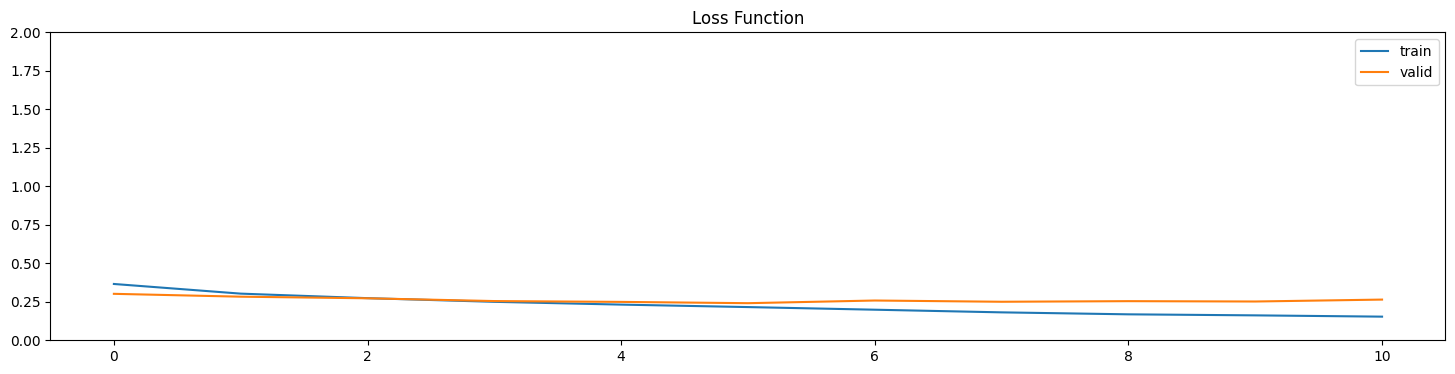

In [29]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.ylim(0, 2)
plt.title('Loss Function')
plt.show()

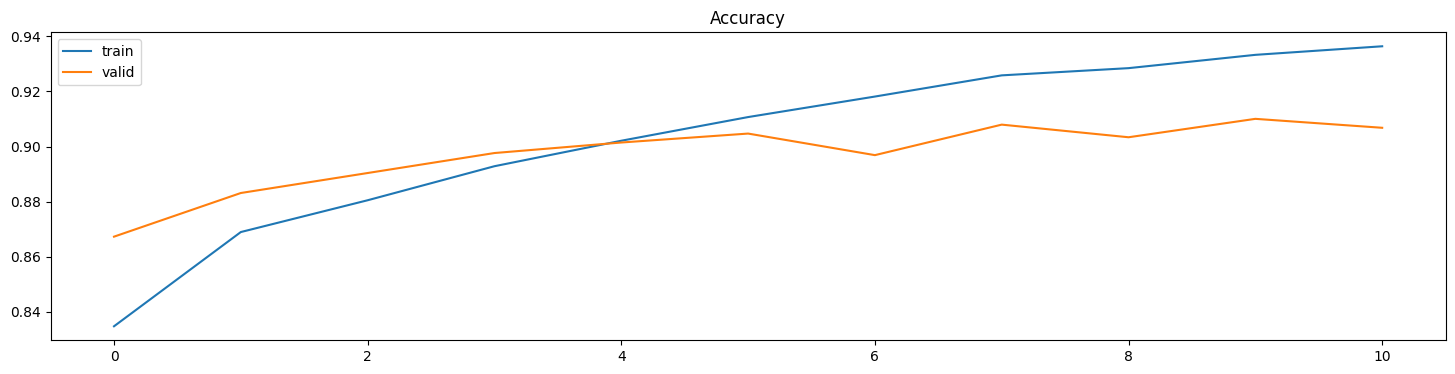

In [30]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [31]:
# test
test_loss, test_acc = our_model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 16s - loss: 0.2642 - accuracy: 0.9068
0.9067990779876709
